In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database  (2017-08-23)
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = [Measurement.date, Measurement.prcp]
data_2017 = session.query(*data).\
    filter(Measurement.date >= last_year)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data_2017, columns=['Date', 'Precipitation'])
# Sort the dataframe by date
df.set_index('Date', inplace=True)
df_sort = df.sort_values(by='Date')
df_sort

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


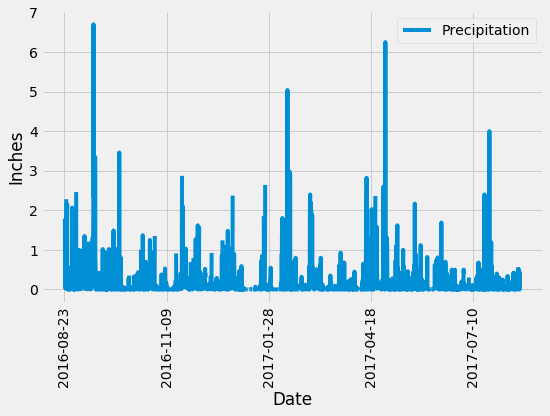

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
df_sort.plot(rot=90, figsize=(8,5))
plt.legend(loc='upper right')
plt.ylabel('Inches')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_sort.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
#Both of these queries work and both return 9 stations
#stn = session.query(Station.station).count()
#stn
stn = session.query(Measurement.station).distinct().count()
stn

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stn_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stn_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#Max Temp
stn_max = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
stn_max

[('USC00519281', 85.0)]

In [16]:
#Min Temp
stn_min = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
stn_min

[('USC00519281', 54.0)]

In [17]:
#Mean Temp
stn_mean = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
stn_mean

[('USC00519281', 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_activity = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
temp_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
temp = [Measurement.date, Measurement.tobs]
temp_2017 = session.query(*temp).\
    filter(Measurement.date >= last_year).\
    filter(Measurement.station == 'USC00519281')

# Save the query results as a Pandas DataFrame and set the index to the date column
df_temp = pd.DataFrame(temp_2017, columns=['Date', 'Temp'])
# Sort the dataframe by date
df_temp.set_index('Date', inplace=True)
temp_sort = df_temp.sort_values(by='Date')
temp_sort


,Temp
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


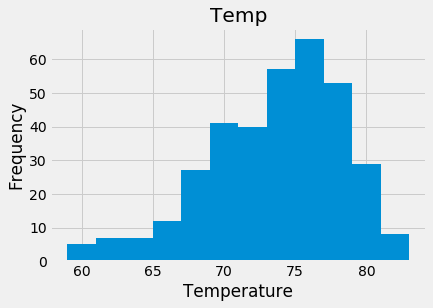

In [20]:
temp_sort.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2016-09-21', '2016-09-28')


[(73.0, 78.09615384615384, 83.0)]

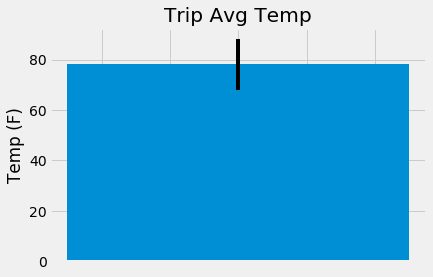

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temps = []
temps.append(calc_temps('2016-09-21', '2016-09-28'))
x = 1
plt.bar(x, temps[0][0][1], yerr=temps[0][0][2]-temps[0][0][0], width=.5)
plt.title("Trip Avg Temp")
plt.ylabel('Temp (F)')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.show()


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
